TGS is one of the leading Geo-science and Data companies which uses seismic images and 3D renderings to understand which areas beneath the Earth’s surface which contain large amounts of oil and gas. Interestingly, the surfaces which contain oil and gas, also contain huge deposits of salt. So with the help of seismic technology, they try to predict which areas in the surface of the Earth contain huge amount of salts. Unfortunately, professional seismic imaging requires expert human vision to exactly identify salt bodies. It could cause huge loss for the oil and gas company drillers if the human prediction is incorrect.Thus,TGS hosted a Kaggle Competition, to employ machine vision to solve this task with better efficiency and accuracy.

This notebook provides solution to solve this problem. Dataset link.[https://www.kaggle.com/c/tgs-salt-identification-challenge/data](http://)

In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [2]:

!mkdir test
!unzip -q ../input/tgs-salt-identification-challenge/test.zip -d test
!mkdir train
!unzip -q ../input/tgs-salt-identification-challenge/train.zip -d train


In [3]:
# Set some parameters
im_width = 128
im_height = 128
border = 5

In [4]:
ids = next(os.walk("./train/images/"))[2] # list of names all images in the given path
print("No. of images = ", len(ids))

No. of images =  4000


In [5]:
X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.bool)


In [6]:
# tqdm is used to display the progress bar
for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
    # Load images
    img = load_img("./train/images/"+id_, grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (128, 128, 1), mode = 'constant', preserve_range = True)
    # Load masks
    mask = img_to_array(load_img("./train/masks/"+id_, grayscale=True))
    mask = resize(mask, (128, 128, 1), mode = 'constant', preserve_range = True)
    # Save images
    X[n] = x_img/255.0
    y[n] = mask/255.0


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [7]:

# Split train and valid

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)


Text(0.5, 1.0, 'Salt')

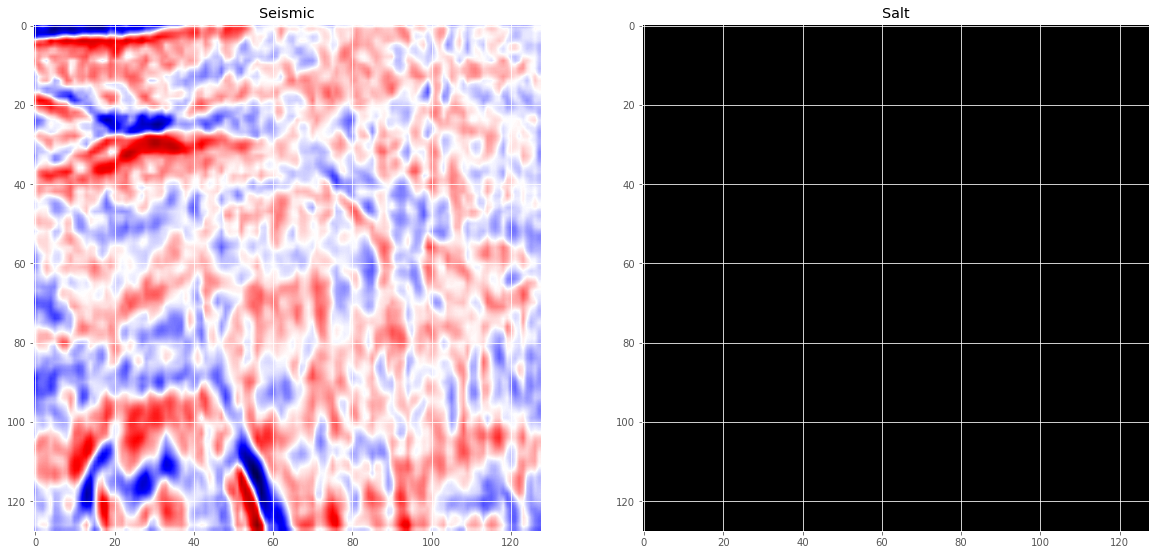

In [8]:
# Visualize any randome image along with the mask
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # salt indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[ix, ..., 0], cmap = 'seismic', interpolation = 'bilinear')
if has_mask: # if salt
    # draw a boundary(contour) in the original image separating salt and non-salt areas
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('Seismic')

ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Salt')

In [9]:
# Another method
from keras import backend as K
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

In [10]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [11]:

def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [12]:
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=[dice_coef])

In [13]:

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 128, 16) 0           batch_normalization_1[0][0]      
_______________________________________________________________________________________

In [14]:

callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [15]:
results = model.fit(X_train, y_train, batch_size=8, epochs=30, callbacks=callbacks,validation_data=(X_valid, y_valid))


Epoch 1/30
449/450 [============================>.] - ETA: 0s - loss: 0.5052 - dice_coef: 0.4239
Epoch 00001: val_loss improved from inf to 0.47910, saving model to model-tgs-salt.h5
450/450 [==============================] - 7s 15ms/step - loss: 0.5050 - dice_coef: 0.4242 - val_loss: 0.4791 - val_dice_coef: 0.5310
Epoch 2/30
448/450 [============================>.] - ETA: 0s - loss: 0.3669 - dice_coef: 0.5280
Epoch 00002: val_loss improved from 0.47910 to 0.31886, saving model to model-tgs-salt.h5
450/450 [==============================] - 6s 14ms/step - loss: 0.3675 - dice_coef: 0.5275 - val_loss: 0.3189 - val_dice_coef: 0.5945
Epoch 3/30
449/450 [============================>.] - ETA: 0s - loss: 0.3149 - dice_coef: 0.5967
Epoch 00003: val_loss did not improve from 0.31886
450/450 [==============================] - 6s 14ms/step - loss: 0.3148 - dice_coef: 0.5968 - val_loss: 0.3534 - val_dice_coef: 0.5372
Epoch 4/30
449/450 [============================>.] - ETA: 0s - loss: 0.2961 - d

Epoch 29/30
450/450 [==============================] - ETA: 0s - loss: 0.1218 - dice_coef: 0.8376
Epoch 00029: val_loss did not improve from 0.16859
450/450 [==============================] - 6s 14ms/step - loss: 0.1218 - dice_coef: 0.8376 - val_loss: 0.1735 - val_dice_coef: 0.8066
Epoch 30/30
447/450 [============================>.] - ETA: 0s - loss: 0.1181 - dice_coef: 0.8361
Epoch 00030: val_loss did not improve from 0.16859
450/450 [==============================] - 6s 14ms/step - loss: 0.1186 - dice_coef: 0.8362 - val_loss: 0.1739 - val_dice_coef: 0.8066


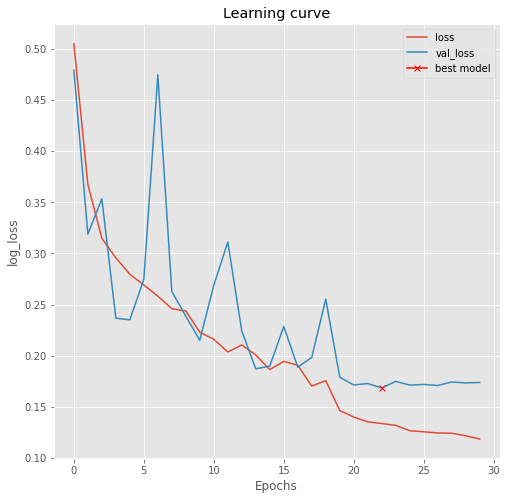

In [16]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [17]:
# load the best model
model.load_weights('model-tgs-salt.h5')

In [18]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_valid, y_valid, verbose=1)

13/13 [==============================] - 0s 18ms/step - loss: 0.1686 - dice_coef: 0.8099


[0.16859406232833862, 0.8099294304847717]

In [19]:
# Predict on train and val 
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)


13/13 [==============================] - 0s 11ms/step


In [20]:
# Threshold predictions
preds_train_t = (preds_train > 0.7).astype(np.uint8)
preds_val_t = (preds_val > 0.7).astype(np.uint8)

In [21]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Salt')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Salt Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Salt Predicted binary');

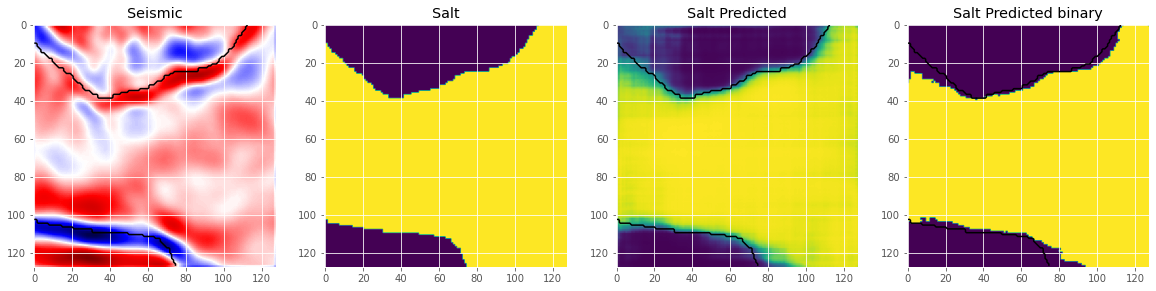

In [22]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=14)

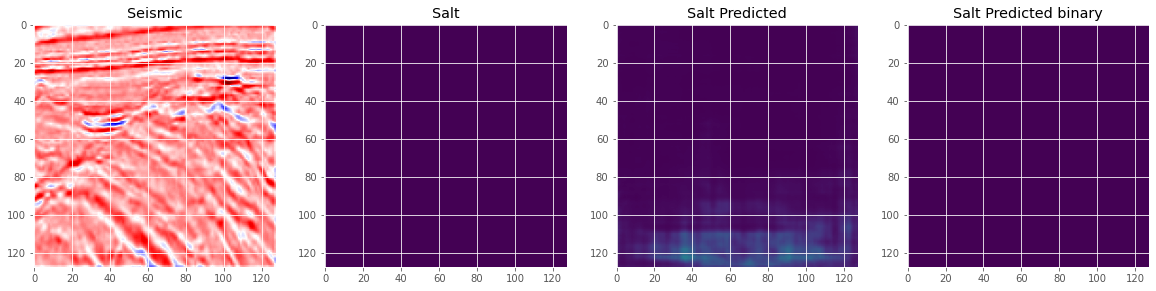

In [23]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

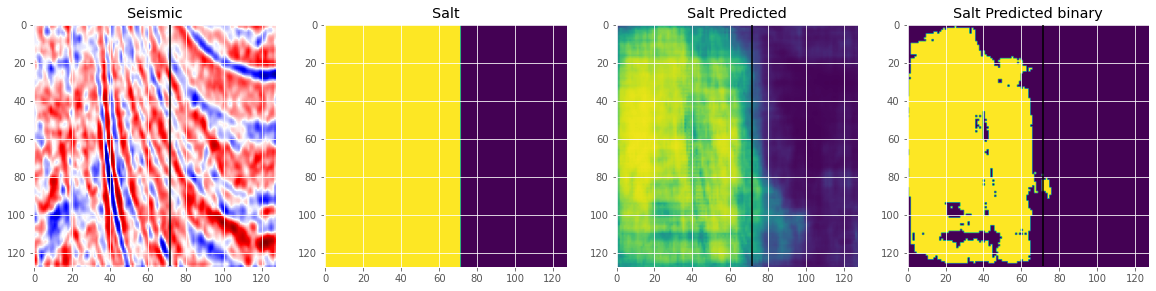

In [24]:

plot_sample(X_train, y_train, preds_train, preds_train_t)

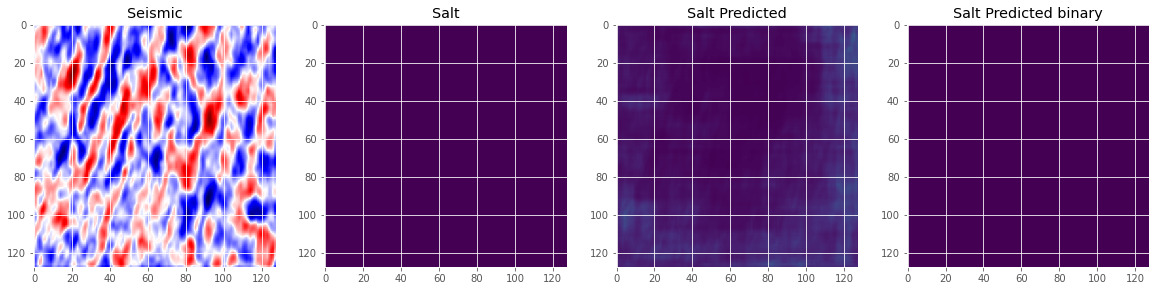

In [25]:

# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=19)

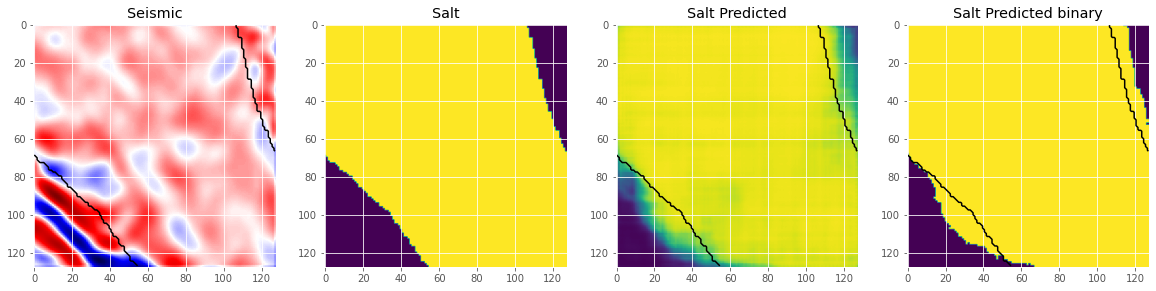

In [26]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

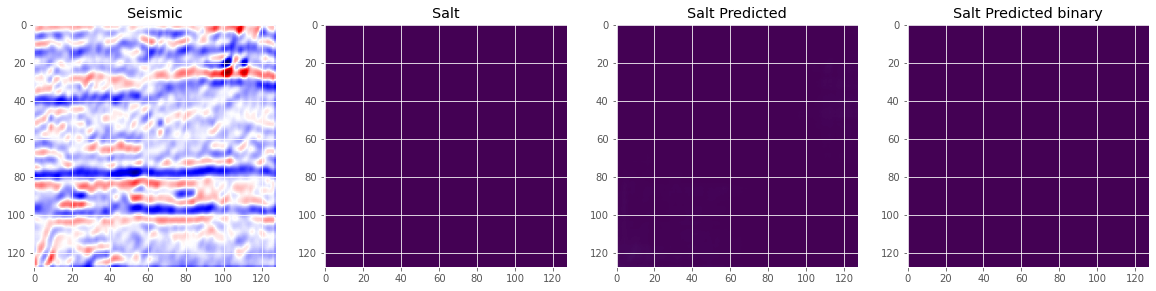

In [27]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

In [28]:
Test_Image_folder='./test/images/'
Test_Image_name=os.listdir(path=Test_Image_folder)
Test_Image_path=[]
Test_id=[]
for i in Test_Image_name:
    path=Test_Image_folder+i
    id2=i.split(sep='.')[0]
    Test_Image_path.append(path)
    Test_id.append(id2)
df_Test_path=pd.DataFrame({'id':Test_id,'Test_Image_path':Test_Image_path})
df_depths=pd.read_csv('../input/tgs-salt-identification-challenge/depths.csv')
df_sub=pd.read_csv('../input/tgs-salt-identification-challenge/sample_submission.csv')
df_Test_path=df_sub.merge(df_Test_path,on='id',how='left')
print(df_Test_path.shape)

(18000, 3)


In [29]:
# Get and resize test images
def read_image2(path,img_height,img_width,img_chan):
    pixel=np.zeros((len(path), img_height, img_width, img_chan),dtype=np.float32)
    sizes_test = []
    for n, p in tqdm_notebook(enumerate(path), total=len(path)):
        img = load_img(p)
        x = img_to_array(img)[:,:,1]
        sizes_test.append([x.shape[0], x.shape[1]])
        x = resize(x, (128, 128, 1), mode='constant', preserve_range=True)
        x=x/255
        pixel[n]=x
    return pixel,sizes_test
img_height=128
img_width=128
img_chan=1
Test_Image_pixel,sizes_test=read_image2(df_Test_path.Test_Image_path,img_height,img_width,img_chan)
print('Test Image shape: ',Test_Image_pixel.shape)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """



Test Image shape:  (18000, 128, 128, 1)


In [30]:
test=Test_Image_pixel
print(test.shape)

(18000, 128, 128, 1)


In [31]:
preds_test = model.predict(test ,verbose=1)
preds_test.shape

563/563 [==============================] - 7s 12ms/step


(18000, 128, 128, 1)

In [32]:
preds_test = (preds_test > 0.7).astype(np.uint8)

In [33]:
# Create list of upsampled test masks
preds_test_upsampled = []
for i in tnrange(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  This is separate from the ipykernel package so we can avoid doing imports until


In [34]:
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1
     # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

In [35]:
pred_dict = {fn[:-4]:RLenc(np.round(preds_test_upsampled[i])) for i,fn in tqdm_notebook(enumerate(df_Test_path.Test_Image_path))}

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


In [36]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
rle=sub[0].values
df_sub.rle_mask=rle

In [37]:
df_sub.head()

,id,rle_mask
0,155410d6fa,104 92 204 97 305 97 406 97 507 97 608 97 709 ...
1,78b32781d1,160 42 259 44 359 45 459 46 559 47 659 48 760 ...
2,63db2a476a,7063 2 7164 2 7264 3 7365 3 7371 2 7467 2 7472...
3,17bfcdb967,4570 1 4648 28 4749 52 4812 14 4850 79 4951 85...
4,7ea0fd3c88,398 1 499 1 599 2 701 1 802 1 903 1 1004 3 110...


In [38]:
df_sub.to_csv('sub1.csv',index=False)